In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-bright")
plt.set_cmap("plasma")

from pathlib import Path

from skylark import skylark_root

df_latency = pd.read_csv(skylark_root / "profiles" / "latency.csv")
src_regions = df_latency["src_region"].unique()
dst_regions = df_latency["dst_region"].unique()

latencies = dict()
for src_region in src_regions:
    for dst_region in dst_regions:
        latency = df_latency[(df_latency["src_region"] == src_region) & (df_latency["dst_region"] == dst_region)]["avg_rtt"].mean()
        latencies[(src_region, dst_region)] = latency


df_merged = pd.read_csv(skylark_root / "profiles" / "throughput.csv")
df_merged["src_cloud"] = df_merged.src_region.str.split(":").str[0]
df_merged["dst_cloud"] = df_merged.dst_region.str.split(":").str[0]
df_merged["inter_cloud"] = df_merged.src_cloud != df_merged.dst_cloud
df_merged["throughput_received"] = df_merged["throughput_received"] / (2**30)
df_merged = df_merged[["src_region", "dst_region", "src_cloud", "dst_cloud", "inter_cloud", "throughput_received"]]
df_merged.rename(columns={"throughput_received": "throughput_gbps"}, inplace=True)

# add latency to df_merged
for index, row in df_merged.iterrows():
    if row["dst_cloud"] == "azure":
        df_merged.at[index, "latency_ms"] = latencies.get((row["dst_region"], row["src_region"]), None)
    else:
        df_merged.at[index, "latency_ms"] = latencies.get((row["src_region"], row["dst_region"]), None)
df = df_merged.dropna()
df

,src_region,dst_region,src_cloud,dst_cloud,inter_cloud,throughput_gbps,latency_ms
1,azure:germanywestcentral,aws:eu-west-2,azure,aws,True,8.730401,16.33300
2,gcp:europe-central2-a,gcp:europe-north1-a,gcp,gcp,False,6.319727,19.05800
3,gcp:europe-west4-a,azure:germanywestcentral,gcp,azure,True,6.503751,10.47250
4,gcp:us-central1-a,gcp:us-east4-a,gcp,gcp,False,6.318297,42.23525
5,gcp:europe-west3-a,aws:eu-west-1,gcp,aws,True,5.637499,23.91450
...,...,...,...,...,...,...,...
7048,aws:ap-northeast-1,gcp:europe-north1-a,aws,gcp,True,2.648411,247.86600
7049,aws:ap-northeast-3,gcp:southamerica-east1-a,aws,gcp,True,2.610008,279.33750
7050,gcp:australia-southeast1-a,gcp:europe-west1-b,gcp,gcp,False,3.301691,267.63575
7051,gcp:europe-west6-a,gcp:australia-southeast1-a,gcp,gcp,False,3.233000,212.74225


<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

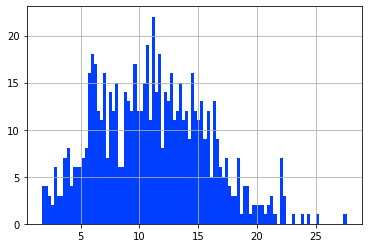

In [18]:
df_gcp = pd.read_csv(skylark_root / "profiles" / "gcp_intracloud_throughput.csv")
df_gcp["src_cloud"] = df_gcp.src_region.str.split(":").str[0]
df_gcp["dst_cloud"] = df_gcp.dst_region.str.split(":").str[0]
df_gcp["inter_cloud"] = df_gcp.src_cloud != df_gcp.dst_cloud
df_gcp["throughput_recieved"] = df_gcp["throughput_recieved"] / (2**30)
df_gcp = df_gcp[["src_region", "dst_region", "src_cloud", "dst_cloud", "inter_cloud", "throughput_recieved"]]
df_gcp.rename(columns={"throughput_recieved": "throughput_gbps"}, inplace=True)

# overwrite df_merged rows with df_gcp rows by (src_region, dst_region)
for index, row in df_gcp.iterrows():
    df.loc[(df["src_region"] == row["src_region"]) & (df["dst_region"] == row["dst_region"]), "throughput_gbps"] = row["throughput_gbps"]

# show distribution of throughput_gbps
df_gcp["throughput_gbps"].hist(bins=100)

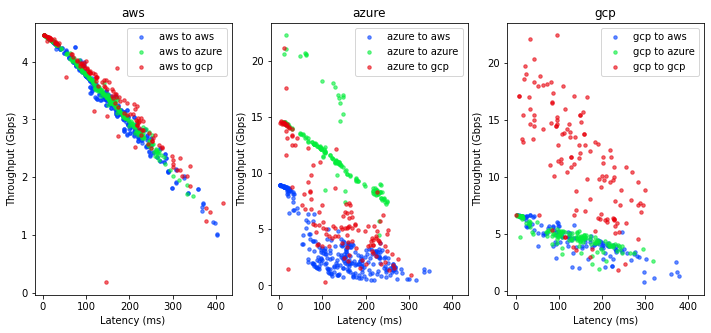

In [19]:
# plot scatter plot of latency versus throughput, color by src_cloud
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=False)
for ax, src_cloud in zip(axs, ["aws", "azure", "gcp"]):
    for dst_cloud in ["aws", "azure", "gcp"]:
        df_sub = df[(df.src_cloud == src_cloud) & (df.dst_cloud == dst_cloud)]
        if src_cloud == "gcp" or dst_cloud == "gcp":
            df_sub = df_sub.sample(min(128, len(df_sub)))
        ax.scatter(df_sub.latency_ms, df_sub.throughput_gbps, label=f"{src_cloud} to {dst_cloud}", alpha=0.6, s=12)
        ax.set_ylabel("Throughput (Gbps)")
        ax.set_xlabel("Latency (ms)")
        ax.set_title(f"{src_cloud}")
        ax.legend()
fig.set_facecolor("white")
fig.savefig(skylark_root / "data/figures" / "latency_vs_throughput.png", bbox_inches="tight", dpi=200)
fig.savefig(skylark_root / "data/figures" / "latency_vs_throughput.pdf", bbox_inches="tight")

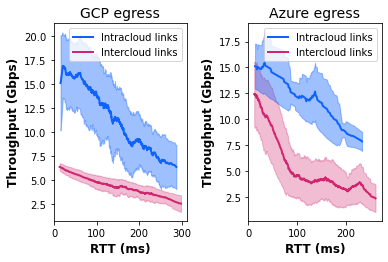

In [20]:
# same plot as above, but show line with confidence interval
color_inter = "#d02670"
color_intra = "#0f62fe"
fig, axs = plt.subplots(1, 2, figsize=(5.5, 3.75), sharex=False, sharey=False)
for ax, src_cloud in zip(axs, ["gcp", "azure"]):

    if src_cloud == "azure":
        w_inter = 96
        w_intra = 28
    else:
        w_inter = 128
        w_intra = 164

    df_intracloud = df[(df.src_cloud == src_cloud) & (df.dst_cloud == src_cloud)].sort_values("latency_ms")
    df_intercloud = df[(df.src_cloud == src_cloud) & (df.dst_cloud != src_cloud)].sort_values("latency_ms")

    # plot intercloud
    mean_df = df_intercloud.sort_values("latency_ms")[["latency_ms", "throughput_gbps"]].rolling(window=w_inter).mean()
    std_df = df_intercloud.sort_values("latency_ms")[["latency_ms", "throughput_gbps"]].rolling(window=w_inter).std()
    ax.plot(mean_df.latency_ms, mean_df.throughput_gbps, label=f"Inter-cloud", alpha=1.0, lw=2, color=color_inter)
    ax.fill_between(
        mean_df.latency_ms,
        mean_df.throughput_gbps - std_df.throughput_gbps,
        mean_df.throughput_gbps + std_df.throughput_gbps,
        alpha=0.3,
        color=color_inter,
    )
    ax.set_ylabel("Throughput (Gbps)", fontsize=12, fontweight="bold")
    ax.set_xlabel("Latency (ms)", fontsize=12, fontweight="bold")
    ax.legend()

    # plot intracloud
    mean_df = df_intracloud.sort_values("latency_ms")[["latency_ms", "throughput_gbps"]].rolling(window=w_intra).mean()
    std_df = df_intracloud.sort_values("latency_ms")[["latency_ms", "throughput_gbps"]].rolling(window=w_intra).std()
    ax.plot(mean_df.latency_ms, mean_df.throughput_gbps, label=f"Intra-cloud", alpha=1.0, lw=2, color=color_intra)
    ax.fill_between(
        mean_df.latency_ms,
        mean_df.throughput_gbps - std_df.throughput_gbps,
        mean_df.throughput_gbps + std_df.throughput_gbps,
        alpha=0.4,
        color=color_intra,
    )
    ax.set_ylabel("Throughput (Gbps)", fontsize=12, fontweight="bold")
    ax.set_xlabel("RTT (ms)", fontsize=12, fontweight="bold")

    if src_cloud == "gcp":
        ax.set_title(f"GCP egress", fontsize=14)
    elif src_cloud == "azure":
        ax.set_title(f"Azure egress", fontsize=14)
    elif src_cloud == "aws":
        ax.set_title(f"AWS egress", fontsize=14)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc="upper right")
fig.tight_layout()
fig.patch.set_facecolor("white")
fig.savefig(skylark_root / "data/figures" / "latency_vs_throughput_inter_intra.png", bbox_inches="tight", dpi=200)
fig.savefig(skylark_root / "data/figures" / "latency_vs_throughput_inter_intra.pdf", bbox_inches="tight")

Text(0, 0.5, 'Throughput (Gbps)')

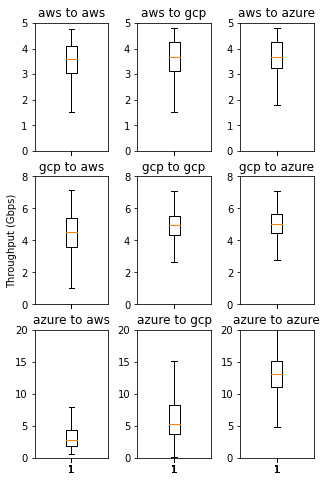

In [12]:
# plot 9 rows in one figure with one boxplot for each row
fig, ax = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(5, 8),
    sharex=True,
    # pad between rows
    gridspec_kw={"hspace": 0.2, "wspace": 0.4},
)
for i, src_cloud in enumerate(["aws", "gcp", "azure"]):
    for j, dst_cloud in enumerate(["aws", "gcp", "azure"]):
        idx = (i, j)
        ax[idx].boxplot(df[(df.src_cloud == src_cloud) & (df.dst_cloud == dst_cloud)].throughput_received / 1e9, showfliers=False)
        ax[idx].set_title(f"{src_cloud} to {dst_cloud}")
        # set scale to 0-12.5Gbps
        bw = [5, 8, 20]
        ax[idx].set_ylim(0, bw[i])
fig.patch.set_facecolor("white")
ax[1, 0].set_ylabel("Throughput (Gbps)")